In [1]:
using HarmonicBalance

┌ Info: Precompiling HarmonicBalance [e13b9ff6-59c3-11ec-14b1-f3d2cc6c135e]
└ @ Base loading.jl:1662


## Duffing resonator

In [2]:
@variables ω, ω0, α, t, γ, F, x(t) # declare constant variables and a function x(t)
diff_eq_duffing = DifferentialEquation(d(x,t,2) + ω0^2*x + γ*d(x,t) + α*x^3 ~ F*cos(ω*t), x)

add_harmonic!(diff_eq_duffing, x, ω) #specify the ansatz x = u(T) cos(ωt) + v(T) sin(ωt)

System of 1 differential equations
Variables:       x(t)
Harmonic ansatz: x(t) => ω;   

α*(x(t)^3) + (ω0^2)*x(t) + γ*Differential(t)(x(t)) + Differential(t)(Differential(t)(x(t))) ~ F*cos(t*ω)


In [3]:
harmonic_eq_duffing = get_harmonic_equations(diff_eq_duffing)

A set of 2 harmonic equations
Variables: u1(T), v1(T)
Parameters: α, ω, γ, ω0, F

Harmonic ansatz: 
x(t) = u1(T)*cos(ωt) + v1(T)*sin(ωt)

Harmonic equations:

γ*Differential(T)(u1(T)) + (ω0^2)*u1(T) + (3//4)*α*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^2)*u1(T) - (ω^2)*u1(T) ~ F

(ω0^2)*v1(T) + γ*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^3) + (3//4)*α*(u1(T)^2)*v1(T) - (ω^2)*v1(T) - (2//1)*ω*Differential(T)(u1(T)) - γ*ω*u1(T) ~ 0


### Single harmonic ansatz drive near resonance

In [4]:
fixed = (α => 1., ω0 => 1.0, F => 0.01, γ=>0.01) # fixed parameters
varied = ω => LinRange(0.9, 1.4, 150)              # range of parameter values
result = get_steady_states(harmonic_eq_duffing, varied, fixed)

Tracking 9 paths... 100%|███████████████████████████████| Time: 0:00:16
  # paths tracked:                  9
  # non-singular solutions (real):  3 (0)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         3 (0)


A steady state result for 150 parameter points

Solution branches:   3
   of which real:    3
   of which stable:  2

Classes: stable, physical, Hopf, binary_labels


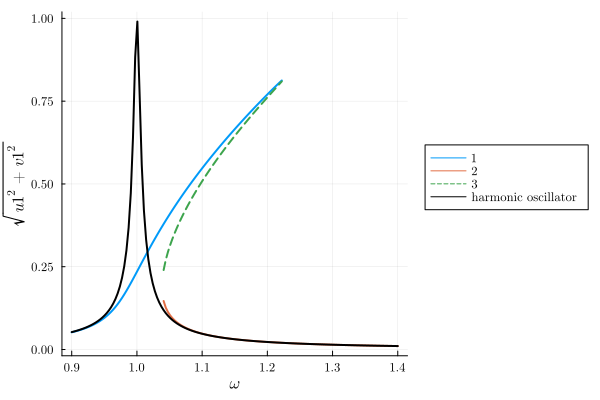

In [5]:
fixed0 = (α => 0., ω0 => 1.0, F => 0.01, γ=>0.01) # fixed parameters
result0 = get_steady_states(harmonic_eq_duffing, varied, fixed0)

plot(result, "sqrt(u1^2+v1^2)")
plot!(result0, "sqrt(u1^2+v1^2)",color="black",label="harmonic oscillator")

Implement left and right frequency sweeps

In [6]:
right_sweep = ParameterSweep(ω=>(0.9, 1.4), (0, 2E4)) # linearly interpolate between two values at two times
ode_problem_right =  HarmonicBalance.TimeEvolution.ODEProblem(harmonic_eq_duffing, fixed, sweep=right_sweep, x0=[0.01;0.], timespan=(0, 2E4))

left_sweep = ParameterSweep(ω=>(1.4,0.9), (0, 2E4)) # linearly interpolate between two values at two times
ode_problem_left =  HarmonicBalance.TimeEvolution.ODEProblem(harmonic_eq_duffing, fixed, sweep=left_sweep, x0=[0.01;0.], timespan=(0, 2E4))

time_soln_right = HarmonicBalance.TimeEvolution.DifferentialEquations.solve(ode_problem_right, saveat=100);
time_soln_left  = HarmonicBalance.TimeEvolution.DifferentialEquations.solve(ode_problem_left, saveat=100);

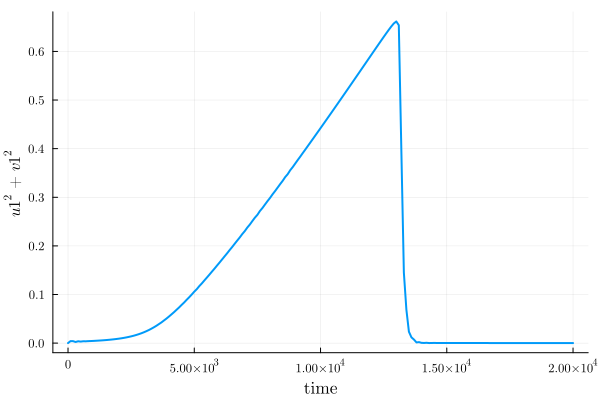

In [7]:
plot(time_soln_right, "u1^2 + v1^2", harmonic_eq_duffing)

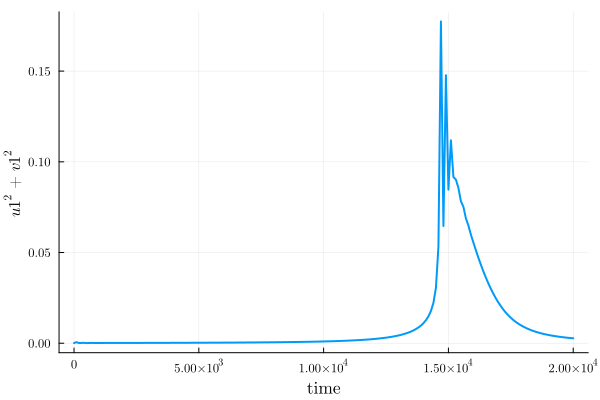

In [8]:
plot(time_soln_left, "u1^2 + v1^2", harmonic_eq_duffing)

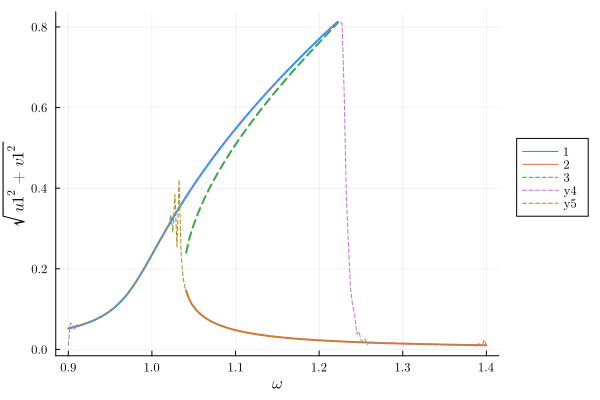

In [9]:
plot(result, "sqrt(u1^2+v1^2)")
plot!(reverse(left_sweep[ω].(time_soln_right.t)),sqrt.(time_soln_right[1,:].^2+time_soln_right[2,:].^2),style=:dash)
plot!(reverse(right_sweep[ω].(time_soln_left.t)),sqrt.(time_soln_left[1,:].^2+time_soln_left[2,:].^2),style=:dash)


Steady state behaviour: benchmark results with solutions to full and averaged differential equations

In [10]:
function Duffing!(dx,x,fixed,t)
    dx[1] = x[2]
    dx[2] = -fixed[ω0]^2*x[1] - fixed[γ]*x[2] - fixed[α]*x[1]^3 + fixed[F0]*cos(fixed[ω]*t) 
end

x0 = [1.,0.]
tspan = (0.0,2000.0)

@variables ω, ω0, F0, t, γ # declare constant variables 

fixed = Dict(ω0 => 1.0, γ => 0.01, F0 => 0.01,  ω=>1.1, α=>1.) #fixed parameters in the simulation 
prob = HarmonicBalance.TimeEvolution.DifferentialEquations.ODEProblem(Duffing!,x0,tspan,fixed)
sol = HarmonicBalance.TimeEvolution.DifferentialEquations.solve(prob,saveat=0.01);

plot(sol.t,sol[1,:],linewidth=5,label=nothing,xlabel="time",ylabel="x(t)")



###calculate steadystate amplitude
fixed = (α => 1., ω0 => 1.0, F => 0.01, γ=>0.01) # fixed parameters
varied = ω => [1.1,1.1]      # range of parameter values
result = get_steady_states(harmonic_eq_duffing, varied, fixed)

res_steady = get_steady_states(harmonic_eq_duffing,varied,fixed)
A_steady = transform_solutions(res_steady,"sqrt(u1^2+v1^2)")
plot(sol.t,sol[1,:],label="HB time evo",xlabel="time",ylabel="x(t)",alpha=0.8)
HarmonicBalance.hline!(real(A_steady[1]),label="HB steady state")

### Attempt falling into different attractors by changing initial conditions

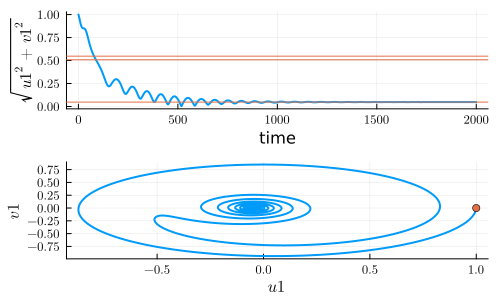

In [11]:
function plot_dynamics_towards_attractor(x0 = [1.,0.])
    #set up problem and solve
    fixed = Dict(ω0 => 1.0, γ => 0.01, F => 0.01,  ω=>1.1, α=>1.) #fixed parameters in the simulation 
    ode_problem_duffing   = HarmonicBalance.TimeEvolution.ODEProblem(harmonic_eq_duffing, fixed, x0 = x0, timespan = (0,2000))

    time_evo = HarmonicBalance.TimeEvolution.DifferentialEquations.solve(ode_problem_duffing, saveat=0.1);

    p1 = plot(time_evo, "sqrt(u1^2+v1^2)", harmonic_eq_duffing)
    HarmonicBalance.hline!(real(A_steady[1]),label="HB steady state")
    p2 = plot(time_evo, ["u1", "v1"], harmonic_eq_duffing)
    plot!([x0[1]],[x0[2]],markers=:true,line=false)

    plot(p1,p2,size=(500,300),layout=(2,1))
end    

plot_dynamics_towards_attractor([1.,0.])

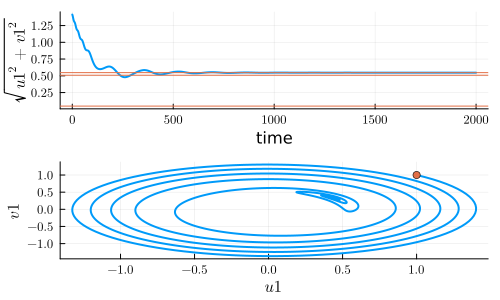

In [12]:
plot_dynamics_towards_attractor([1.,1.])

### More advanced functionality: 2D phase diagrams of steady states

Solving for 10000 parameters... 100%|███████████████████| Time: 0:00:03
  # parameters solved:  10000
  # paths tracked:      30000


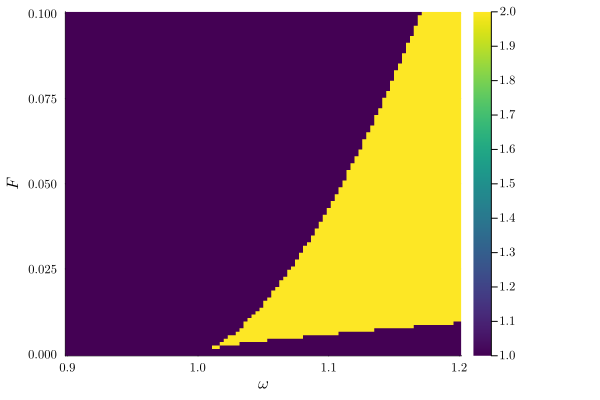

In [13]:
fixed = (α => 1., ω0 => 1.0, γ=>0.01) # fixed parameters

varied = (ω => LinRange(0.9, 1.2, 100), F=>LinRange(0,0.1,100))            # range of parameter values
result2D = get_steady_states(harmonic_eq_duffing, varied, fixed)

plot_phase_diagram(result2D, class="stable") # number of stable solutions as a function of two parameters

Add higher harmonics and analyse down-conversion from largest frequency

In [14]:
# define ODE 
diff_eq_higher = DifferentialEquation(d(x,t,2) + ω0^2*x + α*x^3 + γ*d(x,t) ~ F*cos(5*ω*t), x)

# specify the ansatz x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq_higher, x, ω) 
add_harmonic!(diff_eq_higher, x, 3*ω)
add_harmonic!(diff_eq_higher, x, 5*ω)

System of 1 differential equations
Variables:       x(t)
Harmonic ansatz: x(t) => ω, 3ω, 5ω;   

α*(x(t)^3) + (ω0^2)*x(t) + γ*Differential(t)(x(t)) + Differential(t)(Differential(t)(x(t))) ~ F*cos(5t*ω)


In [15]:
# implement ansatz to get harmonic equations
harmonic_eq = get_harmonic_equations(diff_eq_higher)

A set of 6 harmonic equations
Variables: u1(T), v1(T), u2(T), v2(T), u3(T), v3(T)
Parameters: α, ω, ω0, γ, F

Harmonic ansatz: 
x(t) = u1(T)*cos(ωt) + v1(T)*sin(ωt) + u2(T)*cos(3ωt) + v2(T)*sin(3ωt) + u3(T)*cos(5ωt) + v3(T)*sin(5ωt)

Harmonic equations:

(ω0^2)*u1(T) + γ*Differential(T)(u1(T)) + (3//4)*α*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (3//2)*α*(u2(T)^2)*u1(T) + (3//2)*α*(u3(T)^2)*u1(T) + (3//4)*α*(u1(T)^2)*u2(T) + (3//4)*α*(v1(T)^2)*u1(T) + (3//4)*α*(u2(T)^2)*u3(T) + (3//2)*α*(v2(T)^2)*u1(T) + (3//2)*α*(v3(T)^2)*u1(T) + (3//2)*α*u1(T)*u2(T)*u3(T) + (3//2)*α*u1(T)*v1(T)*v2(T) + (3//2)*α*u1(T)*v2(T)*v3(T) + (3//2)*α*u2(T)*v1(T)*v3(T) + (3//2)*α*u2(T)*v2(T)*v3(T) - (ω^2)*u1(T) - (3//4)*α*(v1(T)^2)*u2(T) - (3//4)*α*(v2(T)^2)*u3(T) - (3//2)*α*u3(T)*v1(T)*v2(T) ~ 0

γ*Differential(T)(v1(T)) + (ω0^2)*v1(T) + (3//4)*α*(v1(T)^3) + (3//4)*α*(u1(T)^2)*v1(T) + (3//2)*α*(u2(T)^2)*v1(T) + (3//4)*α*(u1(T)^2)*v2(T) + (3//4)*α*(v2(T)^2)*v3(T) + (3//2)*α*(u3(T)^2)*v1(T) + (3//

In [16]:
fixed = (α => 1., ω0 => 1.0, F => 0.5, γ=>0.0001)   # fixed parameters
varied = ω => LinRange(0.9, 1.2, 100)              # range of parameter values
result = get_steady_states(harmonic_eq, varied, fixed)

Solving for 100 parameters... 100%|█████████████████████| Time: 0:00:02
  # parameters solved:  100
  # paths tracked:      15300


A steady state result for 100 parameter points

Solution branches:   153
   of which real:    13
   of which stable:  7

Classes: stable, physical, Hopf, binary_labels


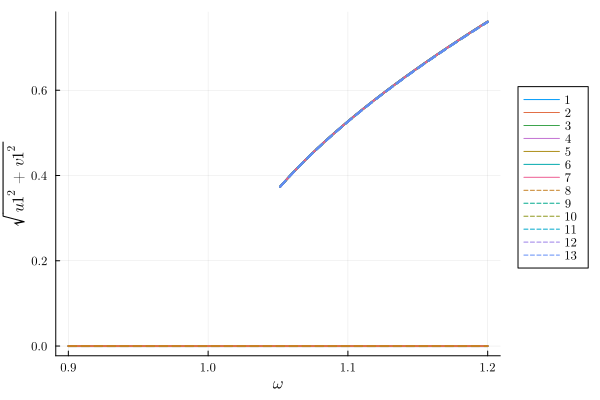

In [17]:
plot(result, x="ω", y="sqrt(u1^2 + v1^2)")